In [1]:
%matplotlib inline


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
texts = ["The caged bird sings with a fearful trill", 
         "for the caged bird sings of freedom"]
cv = CountVectorizer()
d = cv.fit_transform(texts)
# Create a dataframe of the word counts to inspect
# - d.todense() transforms the dtm into a normal (dense) matrix
# - get_feature_names() is a list of the words
pd.DataFrame(d.todense(), columns=cv.get_feature_names()) 

,bird,caged,fearful,for,freedom,of,sings,the,trill,with
0,1,1,1,0,0,0,1,1,1,1
1,1,1,0,1,1,1,1,1,0,0


In [4]:
text = "I haven't seen John's derring-do"
tokenizer = CountVectorizer().build_tokenizer()
tokens_default = tokenizer(text)
print("Scikit-learn default:", tokens_default)
from nltk.tokenize import TreebankWordTokenizer
tokens_treebank = TreebankWordTokenizer().tokenize(text)
print("Treebank tokenizer:", tokens_treebank)



Scikit-learn default: ['haven', 'seen', 'John', 'derring', 'do']
Treebank tokenizer: ['I', 'have', "n't", 'seen', 'John', "'s", 'derring-do']


In [6]:
haiku = "\u53e4\u6c60\u86d9\u98db\u3073\u8fbc\u3080\u6c34\u306e\u97f3"
print("Default tokens", tokenizer(haiku))
import nagisa
print("Nagisa tokens:", nagisa.tagging(haiku).words)

Default tokens ['古池蛙飛び込む水の音']
Nagisa tokens: ['古', '池蛙', '飛び込む', '水', 'の', '音']


In [98]:
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer

sotu = pd.read_csv("http://cssbook.net/d/sotu.csv")
cv = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
d = cv.fit_transform(sotu["text"])
d

<85x22223 sparse matrix of type '<class 'numpy.int64'>'
	with 149566 stored elements in Compressed Sparse Row format>

In [105]:
def termstats(dfm, vectorizer):
    """Helper function to calculate term and document frequency per term"""
    # Frequencies are the column sums of the DFM
    frequencies = dfm.sum(axis=0).tolist()[0]
    # Document frequencies are the binned count of the column indices of DFM entries
    docfreqs = np.bincount(dfm.indices)
    freq_df = pd.DataFrame(dict(frequency=frequencies,
                                docfreq=docfreqs), index=vectorizer.get_feature_names())
    return freq_df.sort_values('frequency', ascending=False)

termstats(d, cv).iloc[[0, 10,  100,  1000, 15000]]

,frequency,docfreq
the,34994,85
for,7124,85
them,691,83
submit,72,41
sizes.,1,1


In [126]:
indices = [cv.vocabulary_[x] for x in ["the", "for", "them", "submit", "sizes."]]
d[[[0], [25], [50], [75]], indices].todense()

matrix([[642,  67,   8,   0,   0],
        [355,  53,   9,   1,   0],
        [182,  56,   5,   0,   0],
        [326,  80,   6,   0,   0]])

(-0.5, 399.5, 199.5, -0.5)

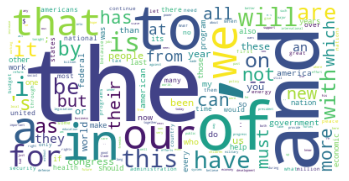

In [70]:
import numpy as np

def wordcloud(dfm, vectorizer, **options):
    freq_dict = dict(zip(vectorizer.get_feature_names(),
                         dfm.sum(axis=0).tolist()[0]))
    return WordCloud(**options).generate_from_frequencies(freq_dict)

wc = wordcloud(d, cv, background_color="white")
plt.imshow(wc)
plt.axis("off")

In [72]:
url = "https://raw.githubusercontent.com/mkearney/trumptweets/master/data/trumptweets-1515775693.tweets.csv"
tweets = pd.read_csv(url, usecols=["status_id", "text"], index_col="status_id")
tweets.head()

,text
status_id,
x1864367186,Read a great interview with Donald Trump that ...
x9273573134835712,Congratulations to Evan Lysacek for being nomi...
x29014512646,I was on The View this morning. We talked abou...
x7483813542232064,Tomorrow night's episode of The Apprentice del...
x5775731054,Donald Trump Partners with TV1 on New Reality ...


(-0.5, 399.5, 199.5, -0.5)

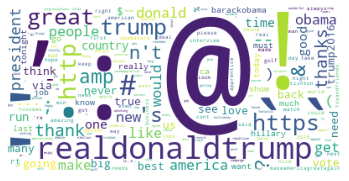

In [152]:
from nltk.corpus import stopwords
cv = CountVectorizer(stop_words=stopwords.words('english'), 
                     tokenizer=TreebankWordTokenizer().tokenize)
d = cv.fit_transform(tweets.text)
wc = wordcloud(d, cv, background_color="white")
plt.imshow(wc)
plt.axis("off")

In [135]:
mystopwords = ["go", "one"] + stopwords.words('english')
print(f"{len(mystopwords)} stopwords: {', '.join(mystopwords[:5])}...")


181 stopwords: go, one, i, me, my...


In [153]:
cv_trim = CountVectorizer(stop_words=stopwords.words('english'),
                     tokenizer=TreebankWordTokenizer().tokenize,
                     max_df=0.75, min_df=0.005)
d_trim = cv_trim.fit_transform(tweets.text)
print(f"# of unique words before trimming: {d.shape[1]}; after trimming: {d_trim.shape[1]}")


/home/wva/ccsbook/env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# of unique words before trimming: 50880; after trimming: 303


In [159]:
termstats(d, cv).iloc[[0, 10,  100,  1000, 15000]]

,frequency,docfreq
the,34994,85
for,7124,85
them,691,83
submit,72,41
sizes.,1,1


In [158]:
count_vectorizer = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
d = count_vectorizer.fit_transform(sotu["text"])
indices = [tfidf_vectorizer.vocabulary_[x] for x in ["the", "for", "them", "submit", "sizes."]]
d[[[0], [25], [50], [75]], indices].todense()

matrix([[642,  67,   8,   0,   0],
        [355,  53,   9,   1,   0],
        [182,  56,   5,   0,   0],
        [326,  80,   6,   0,   0]])

In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=TreebankWordTokenizer().tokenize, sublinear_tf=True)
d_weighted = tfidf_vectorizer.fit_transform(sotu["text"])
indices = [tfidf_vectorizer.vocabulary_[x] for x in ["the", "for", "them", "submit", "sizes."]]
d_weighted[[[0], [25], [50], [75]], indices].todense()

matrix([[0.00098256, 0.00068509, 0.00041488, 0.        , 0.        ],
        [0.00144943, 0.0010483 , 0.00069021, 0.00036207, 0.        ],
        [0.00143613, 0.00116329, 0.00061826, 0.        , 0.        ],
        [0.00112584, 0.0008928 , 0.00047401, 0.        , 0.        ]])

In [168]:
.052 / .013


4.0

In [80]:
import re
from nltk.tokenize import TreebankWordTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords

url = "https://raw.githubusercontent.com/mkearney/trumptweets/master/data/trumptweets-1515775693.tweets.csv"
tweets = pd.read_csv(url, usecols=["status_id", "text"], index_col="status_id")

# 4. Custom preprocessing. Let's tokenize at an indivual tweet to show how it works
tokenizer = WhitespaceTokenizer()

single_tweet = tweets.text.values[tweets.index == "x263687274812813312"][0]
tokens = tokenizer.tokenize(single_tweet)
print(tokens)

# Let's get rid of hyperlinks and HTML escapes before tokenization
single_tweet = re.sub("https?://\\S*|&\\w+;", "", single_tweet)
tokens = tokenizer.tokenize(single_tweet)
print(tokens)

# Now, let's lowercase and drop all stopwords and tokens not starting with a word character
tokens = [t.lower() for t in tokens if re.match("[A-Za-z]", t) and t.lower() not in stopwords.words('english')]
print(tokens)




['Part', '1', 'of', 'my', '@jimmyfallon', 'interview', 'discussing', 'my', '$5M', 'offer', 'to', 'Obama,', '#TRUMP', 'Tower', 'atrium,', 'my', 'tweets', '&amp;', '57th', 'st.', 'crane', 'http://t.co/AvLO9Inf']
['Part', '1', 'of', 'my', '@jimmyfallon', 'interview', 'discussing', 'my', '$5M', 'offer', 'to', 'Obama,', '#TRUMP', 'Tower', 'atrium,', 'my', 'tweets', '57th', 'st.', 'crane']
['part', 'interview', 'discussing', 'offer', 'obama,', 'tower', 'atrium,', 'tweets', 'st.', 'crane']


(-0.5, 599.5, 599.5, -0.5)

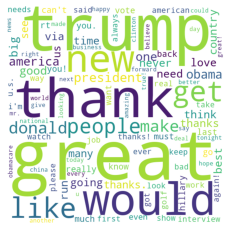

In [79]:
#Now let's do it for the whole corpus
# Drop hyperlinks from data frame
tweets.text = tweets.text.str.replace("https?://\\S*|&\\w+;", "")
# Tokenize all texts, storing the result as a list of lists of tokens
tokens = [tokenizer.tokenize(text) for text in tweets.text.values]
# For each list of tokens, keep only those tokens that start with a letter
tokens = [[t.lower() for t in text_tokens if re.match("[A-Za-z]", t) and t.lower() not in stopwords.words('english')]
          for text_tokens in tokens]
# Create document-term matrix 
def do_nothing(x):
    return x
cv = CountVectorizer(tokenizer=do_nothing, lowercase=False)
dtm_cleaned = cv.fit_transform(tokens)
# Create word cloud
frequencies = dtm_cleaned.sum(axis=0).tolist()[0]
freq_dict = {term: n for (term, n) in zip(cv.get_feature_names(), frequencies)}
wc = WordCloud(background_color="white", max_words=100, width=600, height=600)
wc.generate_from_frequencies(freq_dict)
plt.imshow(wc)
plt.axis("off")


In [7]:
from csv import QUOTE_NONE
embeddings = pd.read_table("glove.6B.50d.txt", sep=" ", index_col=0, header=None, quoting=QUOTE_NONE)

In [13]:
# retrieve embeddings file if not already downloaded
# This is a copy of the first 10k words of the 6B file 
# from https://nlp.stanford.edu/projects/glove/
import urllib.request
glove_fn = 'glove.6B.50d.10k.w2v.txt'
url = f'http://cssbook.net/d/{glove_fn}'
if not os.path.exists(glove_fn):
      urllib.request.urlretrieve (url, glove_fn)

In [16]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format(glove_fn, binary=False)
wv.get_vector('the')

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [65]:
wv.most_similar('fraud')

[('charges', 0.8591152429580688),
 ('bribery', 0.8559849858283997),
 ('alleged', 0.8415062427520752),
 ('corruption', 0.8299386501312256),
 ('allegations', 0.8191748261451721),
 ('theft', 0.802556037902832),
 ('criminal', 0.7997947931289673),
 ('investigating', 0.792083740234375),
 ('investigation', 0.7885714173316956),
 ('laundering', 0.7872843146324158)]

In [64]:
def analogy(a, b, c):
    return wv.most_similar(positive=[b, c], negative=[a])[0][0]
for x in ["king", "boy", "father", "pete", "football"]:
    print(f"Man is to {x} as woman is to {analogy('man', x, 'woman')}")

Man is to king as woman is to queen
Man is to boy as woman is to girl
Man is to father as woman is to mother
Man is to pete as woman is to barbara
Man is to football as woman is to soccer
